In [1]:
%matplotlib inline
import sys
import xarray as xr
import datetime as dt
import pandas as pd
import numpy as np
import cmocean
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

sys.path.append('../../src')
from pynextsim.projection_info import ProjectionInfo
from brkup_utils import lead_detect as lead_det
from brkup_utils import process_data
from brkup_utils import mask_funcs as msk
from brkup_utils import grid_funcs as grd 
from brkup_utils.openerEra5 import OpenerEra5
from brkup_utils.boxnames import *


In [2]:
# read moorings 
indir = '/home/rheinlender/shared-simstore-ns9829k/NANUK/NANUK025-ILBOXE140-S/'    

months = ['01', '02', '03']
years = list(range(2000, 2019))
region='Beaufort'
# subset Beaufort Sea and daily averaged moorings 
ds = process_data.load_moorings(indir,months,years,region=region,period=None)


months: ['01', '02', '03']
years: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
bbox for Beaufort : (95, 225, 425, 575)
DONE!


In [4]:
# create masks
bbox = BOXNAMES[region]
mask_name='nsidc_Beaufort'
Mask = msk.Masking(ds, bbox=bbox)
mask_BS = Mask.get_nsidc_mask(mask_name, depth=None)['data']

msk_moore2022 = Mask.get_Moore2022_Beaufort_mask()

# remove land (nan-values) from Beaufort mask 
ocn_mask = mask_BS*(~np.isnan(ds['sic'][0]))

mskBS_d300 = Mask.get_nsidc_mask(mask_name, depth=300)['data']

# get area info from model grid and add to dataset
cgrd = grd.CREGgrid('../../grid_files', bbox)
ds['cell_area'] = (('y','x'), cgrd.get_area())
ds['cell_area'].attrs = {'units':'m2', 'long_name':'grid_cell_area'}


Getting mask for  nsidc_Beaufort
Getting mask for  ['nsidc_Beaufort_d300']


## Test different leadfraction algorithms 

breakup_paper


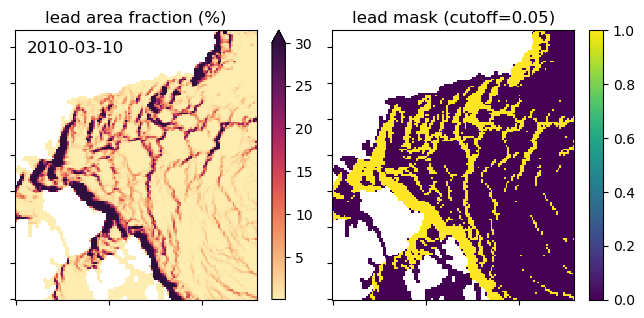

In [6]:
CASENAMES_LIST={'breakup_paper': 0.05 ,'Olason2021':0.05, 
                'Willmes2019':0, 'Martin2004':0, "open-water":0.1}


date = '2010-03-10'

for casename in CASENAMES_LIST:
    print(casename)

    clim = CASENAMES_LIST[casename]

    ds_sel = ds.sel(time=date).mean('time')
    leadfrac, leadmask = lead_det.map_leads(ds_sel, casename, clim)

    # apply land mask
    #leadmask = leadmask.where(landmask==1)
    leadfrac = leadfrac*100
    
    fig, ax = plt.subplots(1,2, figsize=(8,3.5))
    fig.subplots_adjust(hspace=0., wspace=0.05)

    leadfrac.plot(ax=ax[0], vmax=30, cmap=cmocean.cm.matter) # lead fraction
    leadmask.plot(ax=ax[1])

    ax[0].set_title('lead area fraction (%)')
    ax[1].set_title(f'lead mask (cutoff={clim})')
    ax[0].text(0.05, 0.96, date , transform=ax[0].transAxes, fontsize=12, va='top')    

    for axes in ax.flatten(): 
        axes.set_xticklabels([])
        axes.set(xlabel=None)
        axes.set_yticklabels([])
        axes.set(ylabel=None)
        #axes.set(title=None)
    
    #fig.savefig(f'leadFraction_leadMask_JFM_BS_{date}_{casename}.png', dpi=300, bbox_inches='tight')
    
    break


## Compare Lead fraction with and without shelf regions 

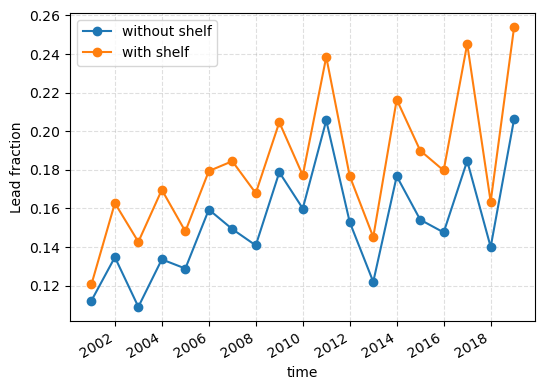

In [9]:
leadfrac, leadmask = lead_det.map_leads(ds, 'breakup_paper', 0.05)

leadfracBS = leadmask.where(ocn_mask).mean(dim=('x', 'y'))
leadfracBS_d300 = leadmask.where(mskBS_d300).mean(dim=('x', 'y')) # removing coastal regions where depth<300m

fig=plt.figure(figsize=(6,4))

leadfracBS_d300.resample(time='Y').mean(dim='time').plot(marker='o', label='without shelf')
leadfracBS.resample(time='Y').mean(dim='time').plot(marker='o', label='with shelf')
plt.grid(ls='--', alpha=0.4)
plt.ylabel('Lead fraction')
plt.legend()

#fig.savefig('compare_leadfract_leadfract-d300_beaufort.png', dpi=300, bbox_inches='tight')


In [ ]:
da_daily = leadfracBS_d300.resample(time='D').mean(dim='time')

month_idxs=da_daily.groupby('time.month').groups

# Extract the time indices corresponding to all the Januarys 
jan_idxs=month_idxs[1]

# Extract the january months by selecting the relevant indices
jan = da_daily.isel(time=jan_idxs)
jan.resample(time='Y').mean(dim='time').plot()

## Compare lead area fraction from `breakup_paper` and `open_water` 

months: ['01', '02', '03']
years: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
bbox for Beaufort : (95, 225, 425, 575)
DONE!
Getting mask for  nsidc_Beaufort
breakup_paper
open-water


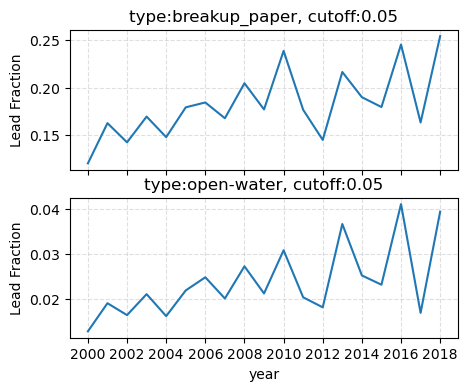

In [15]:

CASENAMES_LIST={'breakup_paper': 0.05 , "open-water":0.05}

fig, ax = plt.subplots(2,1, figsize=(5,4))
for i, casename in enumerate(CASENAMES_LIST):
    print(casename)

    clim = CASENAMES_LIST[casename]

    leadfrac, leadmask = lead_det.map_leads(ds, casename, clim)

    # apply land mask
    leadfracBS = leadmask.where(ocn_mask).mean(dim=('x', 'y'))

    legendLabel=f'type:{casename}, cutoff:{clim}'

    leadfracBS.groupby('time.year').mean('time').plot(ax=ax[i],label=legendLabel) # lead fraction

    ax[i].set_title(legendLabel)
    ax[0].set_xticklabels([]); ax[0].set_xlabel('')
    ax[i].set_xticks(np.arange(2000,2018+2,2))
    ax[i].grid(ls='--', alpha=0.4)
    ax[i].set_ylabel('Lead Fraction')
    
#fig.savefig('leadfrac_test_openwater_breakup_paper_2000-2018.png', dpi=300, bbox_inches='tight')

By only using the open water fraction (and not the young, thin ice) the total lead area fraction is significantly lower.   

## Plot Figure S2

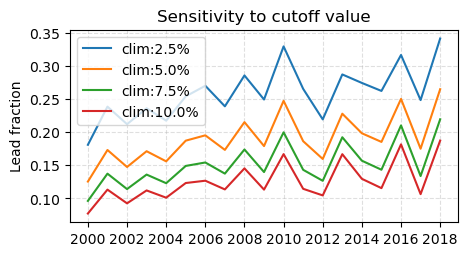

In [24]:
# Sensitivity to cutt off value
casename = 'breakup_paper'
clim = (0.025, 0.05, 0.075, 0.1)

fig, ax = plt.subplots(1,1, figsize=(5,2.5))
for c in clim:
    
    leadfrac, leadmask = ld.map_leads(ds, casename, c)

    # apply land mask
    leadfracBS = leadmask.where(msk_moore2022).mean(dim=('x', 'y'))

    legendLabel=f'clim:{c*100}%'

    leadfracBS.groupby('time.year').mean('time').plot(label=legendLabel) # lead fraction

ax.set_ylabel('Lead fraction')
ax.set_xlabel('')

ax.set_title("Sensitivity to cutoff value")
ax.set_xticks(np.arange(2000,2018+2,2))
ax.grid(ls='--', alpha=0.4)
ax.legend()

fig.savefig('../../figures/' + 'figS02_leadfrac_test_sentitivityToCutoffValue_2000-2018.png', dpi=300, bbox_inches='tight')

## Lead fraction without cut-off value

Beaufort Sea area: 1022836.0735612343 km2
4.393110518118837


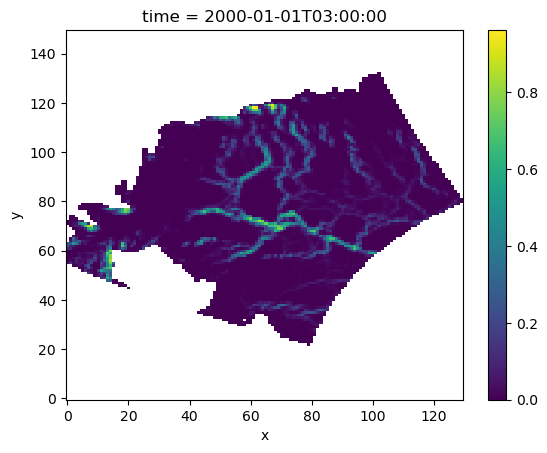

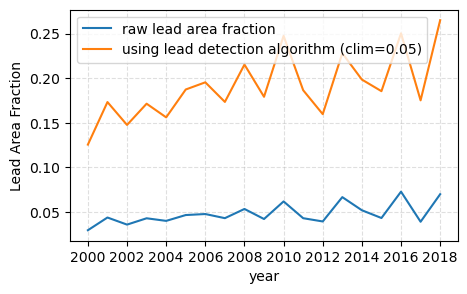

In [46]:
leadfrac, leadmask = lead_det.map_leads(ds, 'breakup_paper', 0.05)

leadfrac005 = leadmask.where(msk_moore2022).mean(dim=('x', 'y'))

# calculate Beaufort area
area_BS = ds['cell_area'].where(msk_moore2022)
area_BS_total = area_BS.sum(dim=('x', 'y'))
print('Beaufort Sea area:', area_BS_total.values*1E-6, 'km2')

leadfrac_BS = leadfrac.where(msk_moore2022)
leadfrac_BS[0].plot.imshow()

lead_area_frac = leadfrac_BS*area_BS
lead_area_frac = lead_area_frac.sum(dim=('x', 'y'))/area_BS_total

print(lead_area_frac[0].values*100)

fig, ax = plt.subplots(1,1, figsize=(5,3))
lead_area_frac.groupby('time.year').mean('time').plot(ax=ax, label='raw lead area fraction')
leadfrac005.groupby('time.year').mean('time').plot(ax=ax, label='using lead detection algorithm (clim=0.05)')
plt.ylabel('Lead Area Fraction')
ax.set_xticks(np.arange(2000,2018+2,2))
ax.grid(ls='--', alpha=0.4)
ax.legend()

#fig.savefig('leadfrac_test_rawVersusProcessed_2000-2018.png', dpi=300, bbox_inches='tight')

## Test Moore2022 box versus standard Beaufort box 

Getting mask for  nsidc_Beaufort


Text(0, 0.5, 'Lead Fraction')

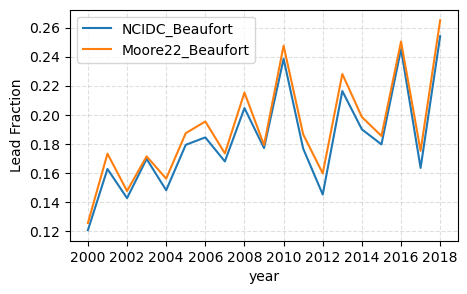

In [17]:
bbox = BOXNAMES[region]
mask_name='nsidc_Beaufort'
Mask = msk.Masking(ds, bbox=bbox)

mask_BS = Mask.get_nsidc_mask(mask_name, depth=None)['data']
msk_BS = mask_BS*(~np.isnan(ds['sic'][0])) # remove land (nan-values) from Beaufort mask 

msk_moore22 = Mask.get_Moore2022_Beaufort_mask()

##############################
# calculate leadfracion
##############################

leadfrac, leadmask = lead_det.map_leads(ds, 'breakup_paper', clim=0.05)

# apply masks
leadfracBS = leadmask.where(msk_BS).mean(dim=('x', 'y'))
leadfracMoore22 = leadmask.where(msk_moore22).mean(dim=('x', 'y'))

##############################
# Plot
##############################

fig, ax = plt.subplots(1,1, figsize=(5,3))
leadfracBS.groupby('time.year').mean('time').plot(ax=ax,label='NCIDC_Beaufort') # lead fraction
leadfracMoore22.groupby('time.year').mean('time').plot(ax=ax,label='Moore22_Beaufort') # lead fraction

ax.legend()
ax.set_xticks(np.arange(2000,2018+2,2))
ax.grid(ls='--', alpha=0.4)
ax.set_ylabel('Lead Fraction')
